# Analysis of Ephys NWB files

In [ ]:
''' @article {R{\"u}bel2021.03.13.435173,
 author = {R{\"u}bel, Oliver and Tritt, Andrew and Ly, Ryan and Dichter, Benjamin K. and Ghosh, Satrajit and Niu, Lawrence and Soltesz, Ivan and Svoboda, Karel and Frank, Loren and Bouchard, Kristofer E.},
 title = {The Neurodata Without Borders ecosystem for neurophysiological data science},
 elocation-id = {2021.03.13.435173},
 year = {2021},
 doi = {10.1101/2021.03.13.435173},
 publisher = {Cold Spring Harbor Laboratory},
 abstract = {The neurophysiology of cells and tissues are monitored electrophysiologically and optically in diverse experiments and species, ranging from flies to humans. Understanding the brain requires integration of data across this diversity, and thus these data must be findable, accessible, interoperable, and reusable (FAIR). This requires a standard language for data and metadata that can coevolve with neuroscience. We describe design and implementation principles for a language for neurophysiology data. Our software (Neurodata Without Borders, NWB) defines and modularizes the interdependent, yet separable, components of a data language. We demonstrate NWB{\textquoteright}s impact through unified description of neurophysiology data across diverse modalities and species. NWB exists in an ecosystem which includes data management, analysis, visualization, and archive tools. Thus, the NWB data language enables reproduction, interchange, and reuse of diverse neurophysiology data. More broadly, the design principles of NWB are generally applicable to enhance discovery across biology through data FAIRness.Competing Interest StatementThe authors have declared no competing interest.},
 URL = {https://www.biorxiv.org/content/early/2021/03/15/2021.03.13.435173},
 eprint = {https://www.biorxiv.org/content/early/2021/03/15/2021.03.13.435173.full.pdf},
 journal = {bioRxiv}
} ''' 

https://pynwb.readthedocs.io/en/stable/overview_citing.html <br>
https://pynwb.readthedocs.io/en/stable/tutorials/index.html <br>
https://pynwb.readthedocs.io/en/stable/tutorials/index.html <br>
https://pynwb.readthedocs.io/en/stable/tutorials/domain/plot_icephys.html#sphx-glr-tutorials-domain-plot-icephys-py

All of this analysis is done in the [conda activate Ephys_env] envirnment as some of the packages require older versions of python, etc.

In [1]:
#%matplotlib inline
#%matplotlib widget
#%matplotlib notebook
'''#TODO: create my own plotting utils - DO NOT use these! they are too long and complicated....'''
# from plot_utils import *
# from neuron_sim_utils import *
import numpy as np
import pandas
import matplotlib.pyplot as plt
#for pulling data for NWB files
import pynwb 
from pynwb.icephys import VoltageClampStimulusSeries, VoltageClampSeries
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
#for analysis of NWB files
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress 
from scipy.signal import chirp, find_peaks, peak_widths
import scipy
import pandas as pd 

In [2]:
cd /Users/samgritz/Desktop/Rutgers/Milstein_Lab/Code/Ephys_Analysis/Ephys_Data 

/Users/samgritz/Desktop/Rutgers/Milstein_Lab/Code/Ephys_Analysis/Ephys_Data


## Opening the NWB File

In [3]:
io = NWBHDF5IO('2022_03_17_Sam_first_cell.nwb', 'r', load_namespaces=True)
read_nwb_file = io.read() 

/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/hdmf/utils.py:629: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


## Using NWB widgets <br>
A potential use for this is to take data from the computer and run it through the widget to visualize which sweeps are the best <br> 
then use the NWBHDF5IO reader to plot and analyze the data <br>
https://nwb-overview.readthedocs.io/en/latest/tools/nwbwidgets/nwbwidgets.html#analysistools-nwbwidgets

In [4]:
nwb2widget(read_nwb_file)

# Scripts for analysis of the data - Interneuron Example

## Get the data for analysis

There is an onset delay of 33.333ms --> 833 so data must start from 833:<br>
And the Fixed frequency acquisition: 25.00 kHz<br>
Current stimulation is from 250ms to 750 ms<br>
So accounting for acquisition and delay, the time values for stim are 6250 to 18750 <br>
Each sweep is 50pA 

In [12]:
acquisition_frequency = 50 #kHz
onset_delay = 33 * acquisition_frequency #ms * kHz 
stimulation_start_idx = 250 * acquisition_frequency #ms * kHz
stimulation_end_idx = 750 * acquisition_frequency #ms * kHz
recording_total_time = 1000 #ms 

In [13]:
data = read_nwb_file.sweep_table.to_dataframe()
data

,series,sweep_number
id,,
0,[data_00000_AD0 pynwb.icephys.VoltageClampSeri...,0
1,[data_00000_DA0 pynwb.icephys.VoltageClampStim...,0
2,[data_00001_AD0 pynwb.icephys.VoltageClampSeri...,1
3,[data_00001_DA0 pynwb.icephys.VoltageClampStim...,1
4,[data_00002_AD0 pynwb.icephys.VoltageClampSeri...,2
...,...,...
111,[data_00055_DA0 pynwb.icephys.CurrentClampStim...,55
112,[data_00056_AD0 pynwb.icephys.CurrentClampSeri...,56
113,[data_00056_DA0 pynwb.icephys.CurrentClampStim...,56


The data will have double the number of sweeps because the first sweep series data is the current stimulation (Computer to Cell - DA), then the response (Cell to Computer - AD) is second - therefore you have to divide the indexing by 2

In [14]:
#Get the data from the NWB file - the even rows are the response data and the odd rows are the stimulus data 
response_data = data.iloc[0::2] #from 0 to the end, step by 2, so get the even rows
# response_data

,series,sweep_number
id,,
0,[data_00000_AD0 pynwb.icephys.VoltageClampSeri...,0
2,[data_00001_AD0 pynwb.icephys.VoltageClampSeri...,1
4,[data_00002_AD0 pynwb.icephys.VoltageClampSeri...,2
6,[data_00003_AD0 pynwb.icephys.VoltageClampSeri...,3
8,[data_00004_AD0 pynwb.icephys.VoltageClampSeri...,4
10,[data_00005_AD0 pynwb.icephys.VoltageClampSeri...,5
12,[data_00006_AD0 pynwb.icephys.VoltageClampSeri...,6
14,[data_00007_AD0 pynwb.icephys.VoltageClampSeri...,7
16,[data_00008_AD0 pynwb.icephys.VoltageClampSeri...,8


[data_00021_AD0 pynwb.icephys.CurrentClampSeries at 0x140231242366688
Fields:
  comments: HS#0:Set Sweep Count: 6.00 a. u.

High precision sweep start: 2022-03-17T23:43:08.766Z
HS#0:Epochs: 0.0000000,0.0200000,Inserted TP;Test Pulse;,0,:0.0000000,0.0050000,Baseline,1,:0.0050000,0.0150000,Inserted TP;Test Pulse;pulse;Amplitude=-50;,1,:0.0150000,0.0200000,Baseline,1,:0.0200000,0.2700000,Baseline,0,:0.2700000,0.5200000,Stimset,0,:0.2700000,0.5200000,Epoch=0;Type=Square pulse;Amplitude=200;,1,:0.5200000,0.7700000,Baseline,0,:

  conversion: 0.0010000000474974513
  data: <HDF5 dataset "data": shape (385000,), type "<f4">
  description: PLACEHOLDER
  electrode: electrode_0 pynwb.icephys.IntracellularElectrode at 0x140231242352528
Fields:
  description: Headstage 0
  device: device_Dev2 pynwb.device.Device at 0x140230994124352
Fields:
  description: Harvard Bioscience (formerly HEKA/Instrutech) Model: Dev2


  gain: 0.0005000000237487257
  rate: 500000.0
  resolution: nan
  starting_time: 156

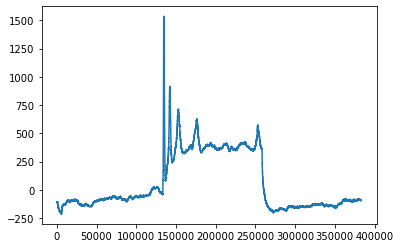

In [15]:
sweep = 21
trace = response_data[response_data['sweep_number']==sweep]['series']
#metadata for the trace
trace_meta = trace.values[0] 
print(trace_meta)

trace = trace.values[0][0].data[onset_delay:]
plt.figure()
plt.plot(trace)


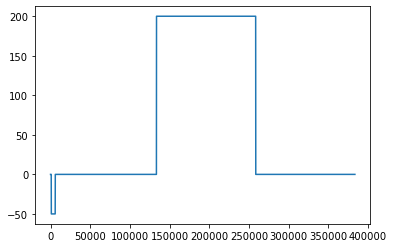

In [16]:
stimulation_data = data.iloc[1::2] #from 1 to the end, step by 2, so get the odd rows 

stim = stimulation_data[stimulation_data['sweep_number']==sweep]['series']
stim = stim.values[0][0].data[onset_delay:]
plt.figure()
plt.plot(stim)


## Data Plot in for loop example

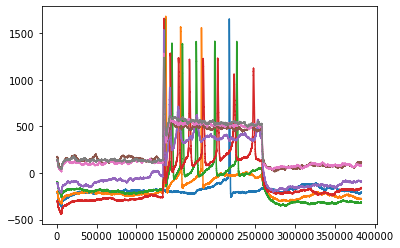

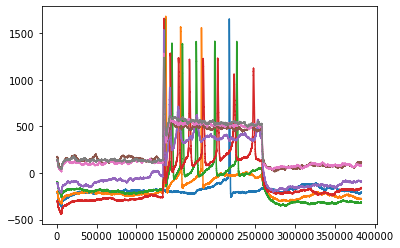

In [18]:
sweep_number_range = np.arange(17,25,1)
traces = []
plt.figure()
for sweeps in sweep_number_range:
    trace = response_data[response_data['sweep_number']==sweeps]['series']
    trace = trace.values[0][0].data[onset_delay:]  
    #print(np.mean(trace[(stimulation_end_idx-10*acquisition_frequency):(stimulation_end_idx)])) 
    plt.plot(trace)
    traces.append(trace)  

plt.figure()
for i in range(len(traces)):    
    plt.plot(traces[i]) 



# Get the IV curve and input resistance

In [86]:
time = np.linspace(0,recording_total_time,acquisition_frequency*1000) #ms 
negative_sweep_number_range = np.arange(344,349,1) 

In [87]:
print((stimulation_end_idx) - (10 * acquisition_frequency))
print((stimulation_end_idx))

print(stimulation_start_idx-10*acquisition_frequency)
print(stimulation_start_idx)

18500
18750
6000
6250


/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:181: RuntimeWarning:

invalid value encountered in double_scalars

/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:195: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:198: RuntimeWarning:

invalid value encountered in double_scalars



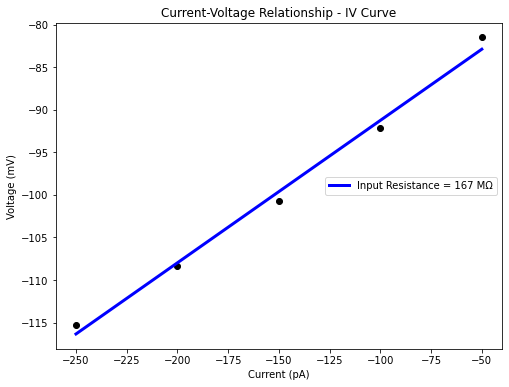

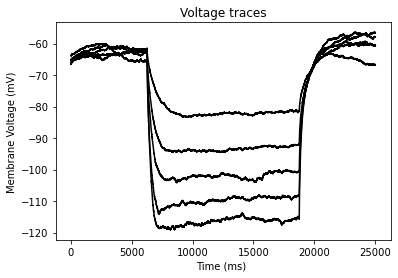

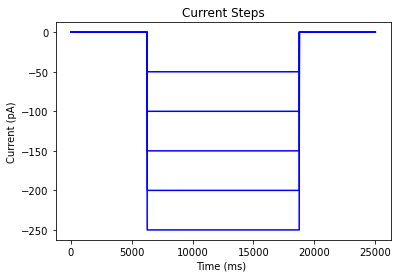

In [88]:
def calculate_IV_curve_properties(negative_sweep_number_range, acquisition_frequency, stimulation_start_idx, stimulation_end_idx):  
    '''Get data for an IV curve for a given set of sweeps'''

    traces = [] 
    mean_baseline_vms = []
    stimulation_current_IV = []
    end_vm_values = []
    voltage_difference_values = []

    for sweeps in negative_sweep_number_range:
        #get the trace
        trace = response_data[response_data['sweep_number']==sweeps]['series']
        trace = trace.values[0][0].data[833:]   
        traces.append(trace) 
        #get the stimulation 
        stim = stimulation_data[stimulation_data['sweep_number']==sweeps]['series']
        stim = stim.values[0][0].data[833:] 
        #To get the pA value and accounting for the acquisition time - Example - index 6250 is 250ms
        stimulation_current_IV.append(stim[stimulation_start_idx])

        '''Generating IV curve'''
        #finding the average vm values cooresponding to last 10ms of current stimulation
        end_vm = np.mean(trace[(stimulation_end_idx-10*acquisition_frequency):(stimulation_end_idx)])
        end_vm_values.append(end_vm)  

        #want to get information 10ms before the stimulation as baseline
        baseline_vm = trace[(stimulation_start_idx-10*acquisition_frequency):(stimulation_start_idx)]
        mean_baseline_vms.append(np.mean(baseline_vm))
        #get voltage difference from baseline
        voltage_difference = np.mean(mean_baseline_vms) - end_vm
        voltage_difference_values.append(voltage_difference) 

        # #get a line through the data - linear regression for raw values
        model = LinearRegression()
        x_values = np.reshape(stimulation_current_IV[::-1],(-1,1))
        model.fit(x_values, end_vm_values[::-1])
        line_prediciton = model.predict(x_values) 

        #Calculate input resistance
        slope, intercept, r_value, p_value, std_err = linregress(stimulation_current_IV[::-1], end_vm_values[::-1])

    return traces, mean_baseline_vms, stimulation_current_IV, end_vm_values, voltage_difference_values, line_prediciton, slope #, intercept, r_value, p_value, std_err

traces, mean_baseline_vms, stimulation_current_IV, end_vm_values, voltage_difference_values, line_prediciton, slope = calculate_IV_curve_properties(negative_sweep_number_range, acquisition_frequency, stimulation_start_idx, stimulation_end_idx)

def plot_IV_curve(stimulation_current_IV, end_vm_values, line_prediciton, slope):
    plt.figure(figsize=(8,6))
    plt.scatter(stimulation_current_IV[::-1],end_vm_values[::-1], color='k')
    plt.plot(stimulation_current_IV[::-1], line_prediciton, color="blue", linewidth=3, label = f'Input Resistance = {int(slope*1000)} MΩ')
    plt.legend(loc = 'center right') 
    plt.title('Current-Voltage Relationship - IV Curve')
    plt.xlabel('Current (pA)')
    plt.ylabel('Voltage (mV)')

plot_IV_curve(stimulation_current_IV, end_vm_values, line_prediciton, slope)


plt.figure()
for sweeps in negative_sweep_number_range:
    trace = response_data[response_data['sweep_number']==sweeps]['series']
    trace = trace.values[0][0].data[onset_delay:]  
    plt.plot(trace, color ='k')
    plt.title('Voltage traces')
    plt.ylabel('Membrane Voltage (mV)')
    plt.xlabel('Time (ms) ')

plt.figure()
for sweeps in negative_sweep_number_range:
    stim = stimulation_data[stimulation_data['sweep_number']==sweeps]['series']
    stim = stim.values[0][0].data[onset_delay:] 
    plt.plot(stim, color ='b')
    plt.title('Current Steps')
    plt.ylabel('Current (pA)')
    plt.xlabel('Time (ms) ')


## Plot FI Curve

In [89]:
positive_sweep_number_range = np.arange(350,355,1)
spike_threshold = -20 #mV


In [90]:
time = np.linspace(0,recording_total_time,acquisition_frequency*1000) #ms 
stimulation_time = np.arange(stimulation_start_idx/acquisition_frequency,stimulation_end_idx/acquisition_frequency,acquisition_frequency) #ms
stimulation_time_size = len(np.arange(stimulation_start_idx/acquisition_frequency,stimulation_end_idx/acquisition_frequency)) #ms 
print(stimulation_time_size)

500


Text(0.5, 0, 'Input Current (pA)')

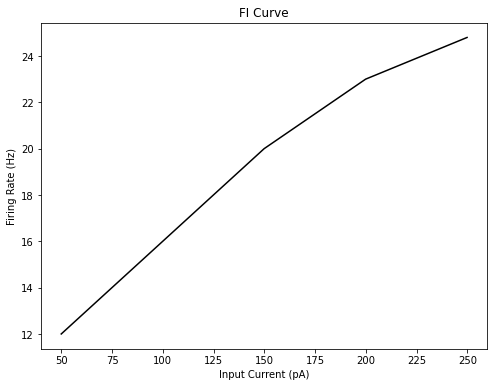

In [91]:
def calculate_FI_curve_properties(positive_sweep_number_range,stimulation_time_size):
    '''Get data for an FI curve for a given set of sweeps'''
    
    firing_rates = []
    avg_firing_rates = []
    stimulation_current_FI = []

    for trace_idx, sweeps in enumerate(positive_sweep_number_range):
            #get the trace
            trace = response_data[response_data['sweep_number']==sweeps]['series']
            trace = trace.values[0][0].data[onset_delay:] 
            trace_data = trace[stimulation_start_idx:stimulation_end_idx]

            #get the current
            stim = stimulation_data[stimulation_data['sweep_number']==sweeps]['series']
            stim = stim.values[0][0].data[onset_delay:]
            stim = stim[stimulation_start_idx:stimulation_end_idx]
            stimulation_current_FI.append(np.mean(stim))

            #find the peaks idx
            #height is the threshold for the peak
            AP_peaks_idx = find_peaks(trace_data, height=spike_threshold)[0]
            firing_rates.append(sum(np.shape(AP_peaks_idx))/((stimulation_time_size)/1000)) #Hz - divide by 1000 because 1kHz = 1ms = 1000Hz 
            avg_firing_rates.append(np.mean(firing_rates))
            
    return stimulation_current_FI, firing_rates, avg_firing_rates 


stimulation_current_FI, firing_rates, avg_firing_rates = calculate_FI_curve_properties(positive_sweep_number_range,stimulation_time_size)

plt.figure(figsize=(8, 6))
plt.plot(stimulation_current_FI,avg_firing_rates,color='k')
#plt.plot(time,voltage_trace_data,color='k')
#plt.scatter(peak_pos, height, color = 'r', s = 15, marker = 'D')
#plt.plot(stimulation_current, line_prediciton, color="blue")
plt.title('FI Curve') 
plt.ylabel('Firing Rate (Hz)')
plt.xlabel('Input Current (pA)')


In [ ]:
# #(401,410,4)
# # positive_sweep_number_range = np.arange(402,410,7)
# positive_sweep_number_range = np.arange(399,410,1)
# spike_threshold = -35

# firing_rates = []
# avg_firing_rate = []
# for positive_sweep_number in positive_sweep_number_range:
#     voltage_trace_data = read_nwb_file.get_acquisition('data_00' + str(positive_sweep_number) + '_AD0')
#     voltage_trace_data = voltage_trace_data.data[833:]
#     #Finding peaks and APs
#     current_spike_mask = find_peaks(voltage_trace_data,
#                                    height=spike_threshold)
#     height = current_spike_mask[1]['peak_heights'] #list of the heights of the peaks
#     peak_pos = current_spike_mask[0]/25 #to account for the frequency of acquisition
#     minima = find_peaks(voltage_trace_data)
#     min_pos = voltage_trace_data[minima[0]] #list of the minima positions
#     min_height = voltage_trace_data[minima[0]] #list of the mirrored minima heights
#     #Measuring rates of positive current sweeps
#     #firing_rates.append(sum(np.shape(peak_pos))/(500/1000)) #500ms to seconds is the timeframe of stimulation
#     firing_rates.append(sum(np.shape(peak_pos))/(500/1000))
#     avg_firing_rate.append(np.mean(firing_rates))
    
# #print(peak_pos)
# print(f'firing rates = {firing_rates}Hz')   

# #print(f'average firing rate = {avg_firing_rate}Hz')   

# stimulation_current = []
# for positive_sweep_number in positive_sweep_number_range:
#     stimulation_data = read_nwb_file.get_stimulus('data_00' + str(positive_sweep_number) + '_DA0')
#     stimulation_data  = stimulation_data.data[833:]
#     #To get the pA value and accounting for the acquisition time - index 6250 is 250ms (750ms -)
#     stimulation_current.append(stimulation_data[6250])
# print(stimulation_current)
# # model = LinearRegression()
# # x_values = np.reshape(stimulation_current,(-1,1))
# # model.fit(x_values, firing_rates)
# # line_prediciton = model.predict(x_values)
# # #slope of FI Curve
# # slope, intercept, r_value, p_value, std_err = linregress(stimulation_current, firing_rates)


# plt.figure(figsize=(8, 6))
# plt.plot(stimulation_current,firing_rates,color='k')
# #plt.plot(time,voltage_trace_data,color='k')
# #plt.scatter(peak_pos, height, color = 'r', s = 15, marker = 'D')
# #plt.plot(stimulation_current, line_prediciton, color="blue")
# plt.title('FI Curve') 
# plt.ylabel('Firing Rate (Hz)')
# plt.xlabel('Input Current (pA)')
# #plt.yticks(np.arange(0, 90, step=20))
# #plt.xticks(np.arange(0, 700, step=100))
# #plt.ylim(-10, 80)
# #plt.savefig('FI_Curve_Inh_Cell.svg') 

## Analyzing Spike data <br>
Parameters to analyze: <br>
- AP Peak (ms and mV)
- AP Size 
- Half-Width - AP and AHP (ms)


In [106]:
#Manual Parameters
positive_sweep_number_range = np.arange(350,355,1) 
AP_peak_window_start = 5 * acquisition_frequency #2 ms before the peak
AP_peak_window_end = 20 * acquisition_frequency #20 ms after the peak
sweep_AP__trace_example_to_plot = 1 #sweep number to plot AP trace of

In [240]:
def calculate_AP_and_AHP_Properties(positive_sweep_number_range,time, plot=False):
    
    #Action Potential Properties
    AP_traces = []
    AP_peaks = []
    AP_sizes = []
    AP_halfwidth_list = [] 

    #After Hyperpolarization Properties
    AHP_sizes = []
    AHP_halfwidth_list = [] 

    for trace_idx, sweeps in enumerate(positive_sweep_number_range):
        #get the trace
        trace = response_data[response_data['sweep_number']==sweeps]['series']
        trace = trace.values[0][0].data[onset_delay:] 
        data = trace[stimulation_start_idx:stimulation_end_idx]
        t= time
        
        #find the peaks idx
        #height is the threshold for the peak
        AP_peaks_idx = find_peaks(data, height=-20)[0] 

        #pull out the Action Potential traces
        prev_peak_idx = 0
        for i, peak_idx in enumerate(AP_peaks_idx):
            window_start = peak_idx - AP_peak_window_start
            if prev_peak_idx > window_start: #avoid measuring the previous AP in the current window
                window_start = prev_peak_idx + int(np.round(0.5*acquisition_frequency)) #if firing rate is very high, set cutoff to 0.5ms after the previous AP
            window_end = peak_idx + AP_peak_window_end

            AP_trace = data[window_start:window_end]
            AP_traces.append(AP_trace)
            prev_peak_idx = peak_idx

            #Find the AP threshold - the greatest rate of change in the AP trace (second derivative or third derivative)
            first_derivative = np.diff(AP_trace)
            second_derivative = np.diff(first_derivative)
            second_derivative = scipy.signal.savgol_filter(second_derivative, 15, 3)
            # third_derivative = np.diff(second_derivative)
            # third_derivative = scipy.signal.savgol_filter(third_derivative, 21, 3)
            # third_deriv_peaks = find_peaks(third_derivative, height=0.1)[0]
            AP_threshold_idx = find_peaks(second_derivative, height=np.max(second_derivative))[0][0] #height is the threshold for derivative
            AP_threshold = AP_trace[AP_threshold_idx] # threshold in mV

            #Action Potential Peak voltages
            AP_peak_idx = AP_peak_window_start # how many ms after the threshold or the AP_peak_window_start
            AP_peak_voltage = AP_trace[AP_peak_idx] # peak in mV
            AP_peaks.append(AP_peak_voltage)

            #Action Potential Sizes
            AP_size = AP_peak_voltage - AP_threshold # AP in mV
            AP_sizes.append(AP_size)

            #Action Potential Halfwidths - halfwidth center point is from the center of the AP to the threshold, width is the distance on both sides of the center point
            AP_halfwidth_voltage = AP_threshold + (AP_size)/2 # halfwidth in mV; AP_peak_voltage - AP_threshold = voltage at the center line, thus add threshold (smaller value) to get the distance from center to the threshold
            AP_halfwidth_start_idx = np.where(AP_trace >= AP_halfwidth_voltage)[0][0]
            AP_halfwidth_end_idx = AP_halfwidth_start_idx + np.where(AP_trace[AP_halfwidth_start_idx:] <= AP_halfwidth_voltage)[0][0] # starting from the halfwidth start, cut off the beginning artifact of the start of the trace, find the first time the voltage is slightly smaller than haldwidth start, as the value on both sides can not be exactly the same
            AP_halfwidth = (AP_halfwidth_end_idx - AP_halfwidth_start_idx)/acquisition_frequency # halfwidth in ms
            AP_halfwidth_list.append(AP_halfwidth)


            #Get the mirror of the AP trace using (-) sign - for After Hyperpolarization
            if len(find_peaks(-AP_trace[AP_threshold_idx:])[0]) == 0: # if there is no trough after the threshold
                AHP_halfwidth = np.NaN
                AHP_size = np.NaN
            else:
                AHP_trough_idx = find_peaks(-AP_trace[AP_threshold_idx:])[0][0] + AP_threshold_idx # starting from the threshold, find the first trough (negative peak)
                AHP_voltage = AP_trace[AHP_trough_idx] # AHP in mV
                AHP_size = AP_threshold - AHP_voltage # AHP size in mV

                #After Hyperpolarization Halfwidths
                AHP_halfwidth_voltage = AHP_voltage + (AP_threshold - AHP_voltage)/2 # AHP halfwidth in mV; AP_threshold - AHP_voltage = the voltage at the center line, thus add the AHP voltage (smaller value) to get the distance from center to the AHP voltage
                AHP_halfwidth_start_idx = AP_peak_idx + np.where(AP_trace[AP_peak_idx:] <= AHP_halfwidth_voltage)[0][0] #find the values smaller than or equal to center line voltage, cut of the values in the beginning so start past the peak 
                
                if len(np.where(AP_trace[AHP_halfwidth_start_idx:]>=AHP_halfwidth_voltage)[0]) == 0: #if the AHP halfwidth voltage is not found in the trace, set the halfwidth to NaN
                    AHP_halfwidth = np.NaN
                else:
                    AHP_halfwidth_end_idx = AHP_halfwidth_start_idx + np.where(AP_trace[AHP_halfwidth_start_idx:] >= AHP_halfwidth_voltage)[0][0] # starting from the halfwidth start, cut off the beginning artifact of the start of the trace, find the first time the voltage is slightly larger than haldwidth start, as the value on both sides can not be exactly the same
                    AHP_halfwidth = (AHP_halfwidth_end_idx - AHP_halfwidth_start_idx)/acquisition_frequency # AHP halfwidth in ms

            AHP_sizes.append(AHP_size) 
            AHP_halfwidth_list.append(AHP_halfwidth)

        avg_AP_halfwidth = np.nanmean(AP_halfwidth_list)        
        avg_AP_size = np.mean(AP_sizes) 
        AP_Total_Number = len(AP_sizes)

        avg_AHP_halfwidth = np.nanmean(AHP_halfwidth_list)
        avg_AHP_size = np.nanmean(AHP_sizes)

        AP_Properties_Table_All_Spikes = pd.DataFrame({'AP_halfwidth (ms)': AP_halfwidth_list, 'AP_size (mV)': AP_sizes, 'AHP_halfwidth (ms)': AHP_halfwidth_list, 
        'AHP_size (mV)': AHP_sizes}) 

        AP_Properties_Table_Avgs = pd.DataFrame({'Sweep_Range': [positive_sweep_number_range], 'AP_Total_Number': AP_Total_Number,'Avg_AP_halfwidth (ms)': [avg_AP_halfwidth] , 'Avg_AP_size (mv)': [avg_AP_size], 
        'Avg_AHP_halfwidth (ms)': [avg_AHP_halfwidth], 'avg_AHP_size (mV)': [avg_AHP_size]}) 

        #avg_AHP_halfwidth, avg_AHP_size, avg_AP_halfwidth, avg_AP_size, AP_Total_Number, AP_peaks, AP_sizes, AHP_sizes,
    return AP_Properties_Table_All_Spikes, AP_Properties_Table_Avgs 

#Must save the outputs as variables to print them
AP_Properties_Table_All_Spikes, AP_Properties_Table_Avgs = calculate_AP_and_AHP_Properties(positive_sweep_number_range,time,plot=False)

AP_Properties_Table_Avgs

/var/folders/w4/_c8ps64n6cxg0m9hl_lh3jgr0000gn/T/ipykernel_45281/2523986546.py:89: RuntimeWarning:

Mean of empty slice



,Sweep_Range,AP_Total_Number,Avg_AP_halfwidth (ms),Avg_AP_size (mv),Avg_AHP_halfwidth (ms),avg_AHP_size (mV)
0,"[350, 351, 352, 353, 354]",62,2.443226,59.071388,4.06,6.873124
